In [2]:
import datetime
import os
import glob
import gc
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib import colors
import cmcrameri.cm as ccm
plt.style.use('science.mplstyle')
projectdir = '/glade/campaign/uwyo/wyom0112/berkeley/'

In [3]:
domains = ['d01', 'd02', 'd03', 'd04']
coordsdict = {}
for domain in domains:
    coordsdict[domain] = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_{domain}')

In [4]:

gcms_dict = {'d01': ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
                     'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
                     'canesm5','access-cm2','ec-earth3'],
             'd02': ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
                     'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
                     'canesm5','access-cm2','ec-earth3'],
             'd03': ['ec-earth3-veg'],
             'd04': ['ec-earth3-veg'],}

variants_dict = {'d01': ['r11i1p1f1','r7i1p1f1','r1i1p1f2',
                         'r1i1p1f1','r1i1p1f1','r2i1p1f2',
                         'r1i1p2f1','r5i1p1f1','r1i1p1f1',],
                 'd02': ['r11i1p1f1','r7i1p1f1','r1i1p1f2',
                         'r1i1p1f1','r1i1p1f1','r2i1p1f2',
                         'r1i1p2f1','r5i1p1f1','r1i1p1f1',],
                 'd03': ['r1i1p1f1'],
                 'd04': ['r1i1p1f1'],}

calendars_dict = {'d01': ['365_day','proleptic_gregorian','proleptic_gregorian',
                         'proleptic_gregorian','365_day','360_day',
                         '365_day','proleptic_gregorian','proleptic_gregorian',],
                 'd02': ['365_day','proleptic_gregorian','proleptic_gregorian',
                         'proleptic_gregorian','365_day','360_day',
                         '365_day','proleptic_gregorian','proleptic_gregorian',],
                 'd03': ['proleptic_gregorian'],
                 'd04': ['proleptic_gregorian'],}

ssps_dict = {'d01': ['ssp370','ssp370','ssp370','ssp370',
                     'ssp370','ssp370','ssp370','ssp370',
                     'ssp370',],
             'd02': ['ssp370','ssp370','ssp370','ssp370',
                     'ssp370','ssp370','ssp370','ssp370',
                     'ssp370',],
             'd03': ['ssp370'],
             'd04': ['ssp370'],}


source_ids = {'access-cm2':'ACCESS-CM2', 
             'cesm2':'CESM2',
             'cnrm-esm2-1':'CNRM-ESM2-1', 
             'canesm5':'CanESM5',
             'ec-earth3':'EC-Earth3',
             'ec-earth3-veg': 'EC-Earth3-Veg',
             'fgoals-g3':'FGOALS-g3', 
             'mpi-esm1-2-lr':'MPI-ESM1-2-LR',
             'ukesm1-0-ll':'UKESM1-0-LL'}

date_start_hist, date_end_hist = "1980-09-01", "2014-08-31"
date_start_ssp, date_end_ssp = "2014-09-01", "2100-08-31"
dir_meta = '/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/'


In [5]:

#Read meta
def _metaread(dir_meta,domain):
 file = "%swrfinput_%s" %(dir_meta,domain)
 data = xr.open_dataset(file)
 lat = data.variables["XLAT"]
 lon = data.variables["XLONG"]
 z = data.variables["HGT"]

 return (lat,lon,z,file)

#WRF reader function
def _wrfread(prefix,dir,var,domain,calendar):

 all_files = sorted(os.listdir(dir))

 anal_files = []
 for ii in all_files:
  if ii.startswith(var+"."):
   if domain in ii:
    if prefix in ii:
     anal_files.append(dir+str(ii))

 del all_files

 nf  = len(anal_files)

 data = xr.open_mfdataset(anal_files, combine="by_coords")
 var_read = data.variables[var]
 day = data.variables["day"].values
 nt = len(day)

 day1 = str ( int ( day[0] ) )
 val1 = day1[0:4]
 val2 = int (day1[4:6])
 val3 = int (day1[6:8])
 print (val1,val2,val3)
 day1_str = "%s-%s-%s" %(val1, "{:0=2d}".format(val2),
                                        "{:0=2d}".format(val3) )

 day2 = str ( int ( day[nt-1] ) )
 val1 = day2[0:4]
 val2 = int (day2[4:6])
 val3 = int (day2[6:8])
 print (val1,val2,val3)
 day2_str = "%s-%s-%s" %(val1, "{:0=2d}".format(val2),
                                        "{:0=2d}".format(val3) )
 time_array = xr.cftime_range(start=day1_str, end=day2_str,
                              freq="1D", calendar=calendar)


 var_read = xr.DataArray(var_read)
 var_read['day'] = time_array    #year doesn't matter here

 return (var_read.rename({'day': 'time'}))

#WRF tier 3 reader function
def _wrfread_gcm(model,gcm,variant,dir,var,domain,calendar):

 all_files = sorted(os.listdir(dir))

 anal_files = []
 for ii in all_files:
  if ii.startswith(var+".") and model in ii and gcm in ii \
        and variant in ii and domain in ii:
   if domain in ii:
     anal_files.append(dir+str(ii))

 del all_files

 nf  = len(anal_files)

 data = xr.open_mfdataset(anal_files, combine="by_coords")
 var_read = data.variables[var]
 day = data.variables["day"].values
 nt = len(day)

 day1 = str ( int ( day[0] ) )
 val1 = day1[0:4]
 val2 = int (day1[4:6])
 val3 = int (day1[6:8])
 day1_str = "%s-%s-%s" %(val1, "{:0=2d}".format(val2),
                                        "{:0=2d}".format(val3) )

 day2 = str ( int ( day[nt-1] ) )
 val1 = day2[0:4]
 val2 = int (day2[4:6])
 val3 = int (day2[6:8])
 day2_str = "%s-%s-%s" %(val1, "{:0=2d}".format(val2),
                                        "{:0=2d}".format(val3) )

 time_array = xr.cftime_range(start=day1_str, end=day2_str,
                              freq="1D", calendar=calendar)   

 var_read = xr.DataArray(var_read)
 var_read['day'] = time_array    #year doesn't matter here

 return (var_read)

def _read_merge(dir,domain,var,gcm,variant,date_start_hist, \
                date_start_ssp,date_end_hist,date_end_ssp,exp,bc,calendar):
    
    dir_x = "%s/%s_%s_historical/postprocess/" %(dir,gcm,variant) + domain + "/"
    
    if bc == True:
        dir_x = "%s/%s_%s_historical_bc/postprocess/" %(dir,gcm,variant) + domain + "/"

    if calendar == '360_day':
        date_end_hist = date_end_hist.split("-")
        date_end_hist = "%s-%s-%s" %(date_end_hist[0],
                                     date_end_hist[1],
                                     int( int(date_end_hist[2]) + 0.0001 - 1) )
        
        date_end_ssp = date_end_ssp.split("-")
        date_end_ssp = "%s-%s-%s" %(date_end_ssp[0],
                                     date_end_ssp[1],
                                     int( int(date_end_ssp[2]) + 0.0001 - 1) )
        
    print (calendar,date_end_hist,date_end_ssp)
    var_wrf = _wrfread_gcm("hist",gcm,variant,dir_x,var,domain,calendar)
    var_hist = var_wrf.sel(day=slice(date_start_hist,date_end_hist))
    dir_x = "%s/%s_%s_%s/postprocess/" %(dir,gcm,variant,exp) + domain + "/"
    
    print (gcm,variant,bc,exp)
    
    if bc == True:
        dir_x = "%s/%s_%s_%s_bc/postprocess/" %(dir,gcm,variant,exp) + domain + "/"

    var_wrf = _wrfread_gcm(exp,gcm,variant,dir_x,var,domain,calendar)
    var_ssp = var_wrf.sel(day=slice(date_start_ssp,date_end_ssp) )
    
    var_combine = xr.concat([var_hist,var_ssp],dim="day").rename({'day': 'time'})
    
    return (var_combine)
    

In [6]:
def make_ds(domain, var = 'snow'):
    gcms = gcms_dict[domain]
    variants = variants_dict[domain]
    ssps = ssps_dict[domain]
    calendars = calendars_dict[domain]
    keys = []
    snow_BC = {}
    snow_noBC = {}
    mydir = '/glade/campaign/uwyo/wyom0112/postprocess/'
    print(len(gcms))
    for count, igcm in enumerate(gcms):
        condition = ()
        bc = True
        key = '%s_%s_%s' %(igcm,variants[count],ssps[count])
        read = _read_merge(mydir,domain,var,
                          igcm,variants[count], \
                          date_start_hist,date_start_ssp, \
                          date_end_hist,date_end_ssp,ssps[count],bc,
                          calendars[count])

        snow_BC[key] = read
        keys.append(key)
        gc.collect()
    for count, igcm in enumerate(gcms):
        condition = ()
        bc = False
        key = '%s_%s_%s' %(igcm,variants[count],ssps[count])
        read = _read_merge(mydir,domain,var,
                          igcm,variants[count], \
                          date_start_hist,date_start_ssp, \
                          date_end_hist,date_end_ssp,ssps[count],bc,
                          calendars[count])

        snow_noBC[key] = read
        gc.collect()
    return (snow_BC, snow_noBC)

def _calendar(data, base_calendar = '365_day'):
    calendar_data = []
    keys = data.keys()
    for key in keys:
        tmp = data[key].convert_calendar(base_calendar, dim='time', align_on='year', missing=None, use_cftime=None)
        calendar_data.append(tmp)
    allout = xr.concat(calendar_data, dim = 'gcm')
    return allout

In [13]:
domain = 'd01'
domains = ['d01','d02','d03', 'd04']
savedir = '/glade/campaign/uwyo/wyom0112/berkeley/'
for domain in domains[1:]:
    snow_BC, snow_noBC = make_ds(domain)
    allsnow_BC = _calendar(snow_BC)
    allsnow_noBC = _calendar(snow_noBC)
    allsnowmax_BC = allsnow_BC.resample(time = '1AS').max()
    allsnowmax_noBC = allsnow_noBC.resample(time = '1AS').max()
    allsnowmax_noBC.to_netcdf(f'{savedir}allsnowmax_noBC_{domain}.nc')
    allsnowmax_BC.to_netcdf(f'{savedir}allsnowmax_BC_{domain}.nc')
    allsnow_BC.to_netcdf(f'{savedir}allsnow_BC_{domain}.nc')
    allsnow_noBC.to_netcdf(f'{savedir}allsnow_noBC_{domain}.nc')
    print(domain)




9
365_day 2014-08-31 2100-08-31
cesm2 r11i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
mpi-esm1-2-lr r7i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
cnrm-esm2-1 r1i1p1f2 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3-veg r1i1p1f1 True ssp370
365_day 2014-08-31 2100-08-31
fgoals-g3 r1i1p1f1 True ssp370
360_day 2014-08-30 2100-08-30
ukesm1-0-ll r2i1p1f2 True ssp370
365_day 2014-08-31 2100-08-31
canesm5 r1i1p2f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
access-cm2 r5i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3 r1i1p1f1 True ssp370
365_day 2014-08-31 2100-08-31
cesm2 r11i1p1f1 False ssp370
proleptic_gregorian 2014-08-31 2100-08-31
mpi-esm1-2-lr r7i1p1f1 False ssp370
proleptic_gregorian 2014-08-31 2100-08-31
cnrm-esm2-1 r1i1p1f2 False ssp370
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3-veg r1i1p1f1 False ssp370
365_day 2014-08-31 2100-08-31
fgoals-g3 r1i1p1f1 False ssp370
360_day 2014-08-30 2100-08-3

In [9]:
savedir = '/glade/campaign/uwyo/wyom0112/berkeley/'
domain = 'd01'
allsnowmax_noBC.to_netcdf(f'{savedir}allsnowmax_noBC_{domain}.nc')


In [10]:
allsnowmax_BC.to_netcdf(f'{savedir}allsnowmax_BC_{domain}.nc')


In [11]:
allsnow_BC.to_netcdf(f'{savedir}allsnow_BC_{domain}.nc')


In [12]:
allsnow_noBC.to_netcdf(f'{savedir}allsnow_noBC_{domain}.nc')


AttributeError: 'DataArray' object has no attribute 'keys'

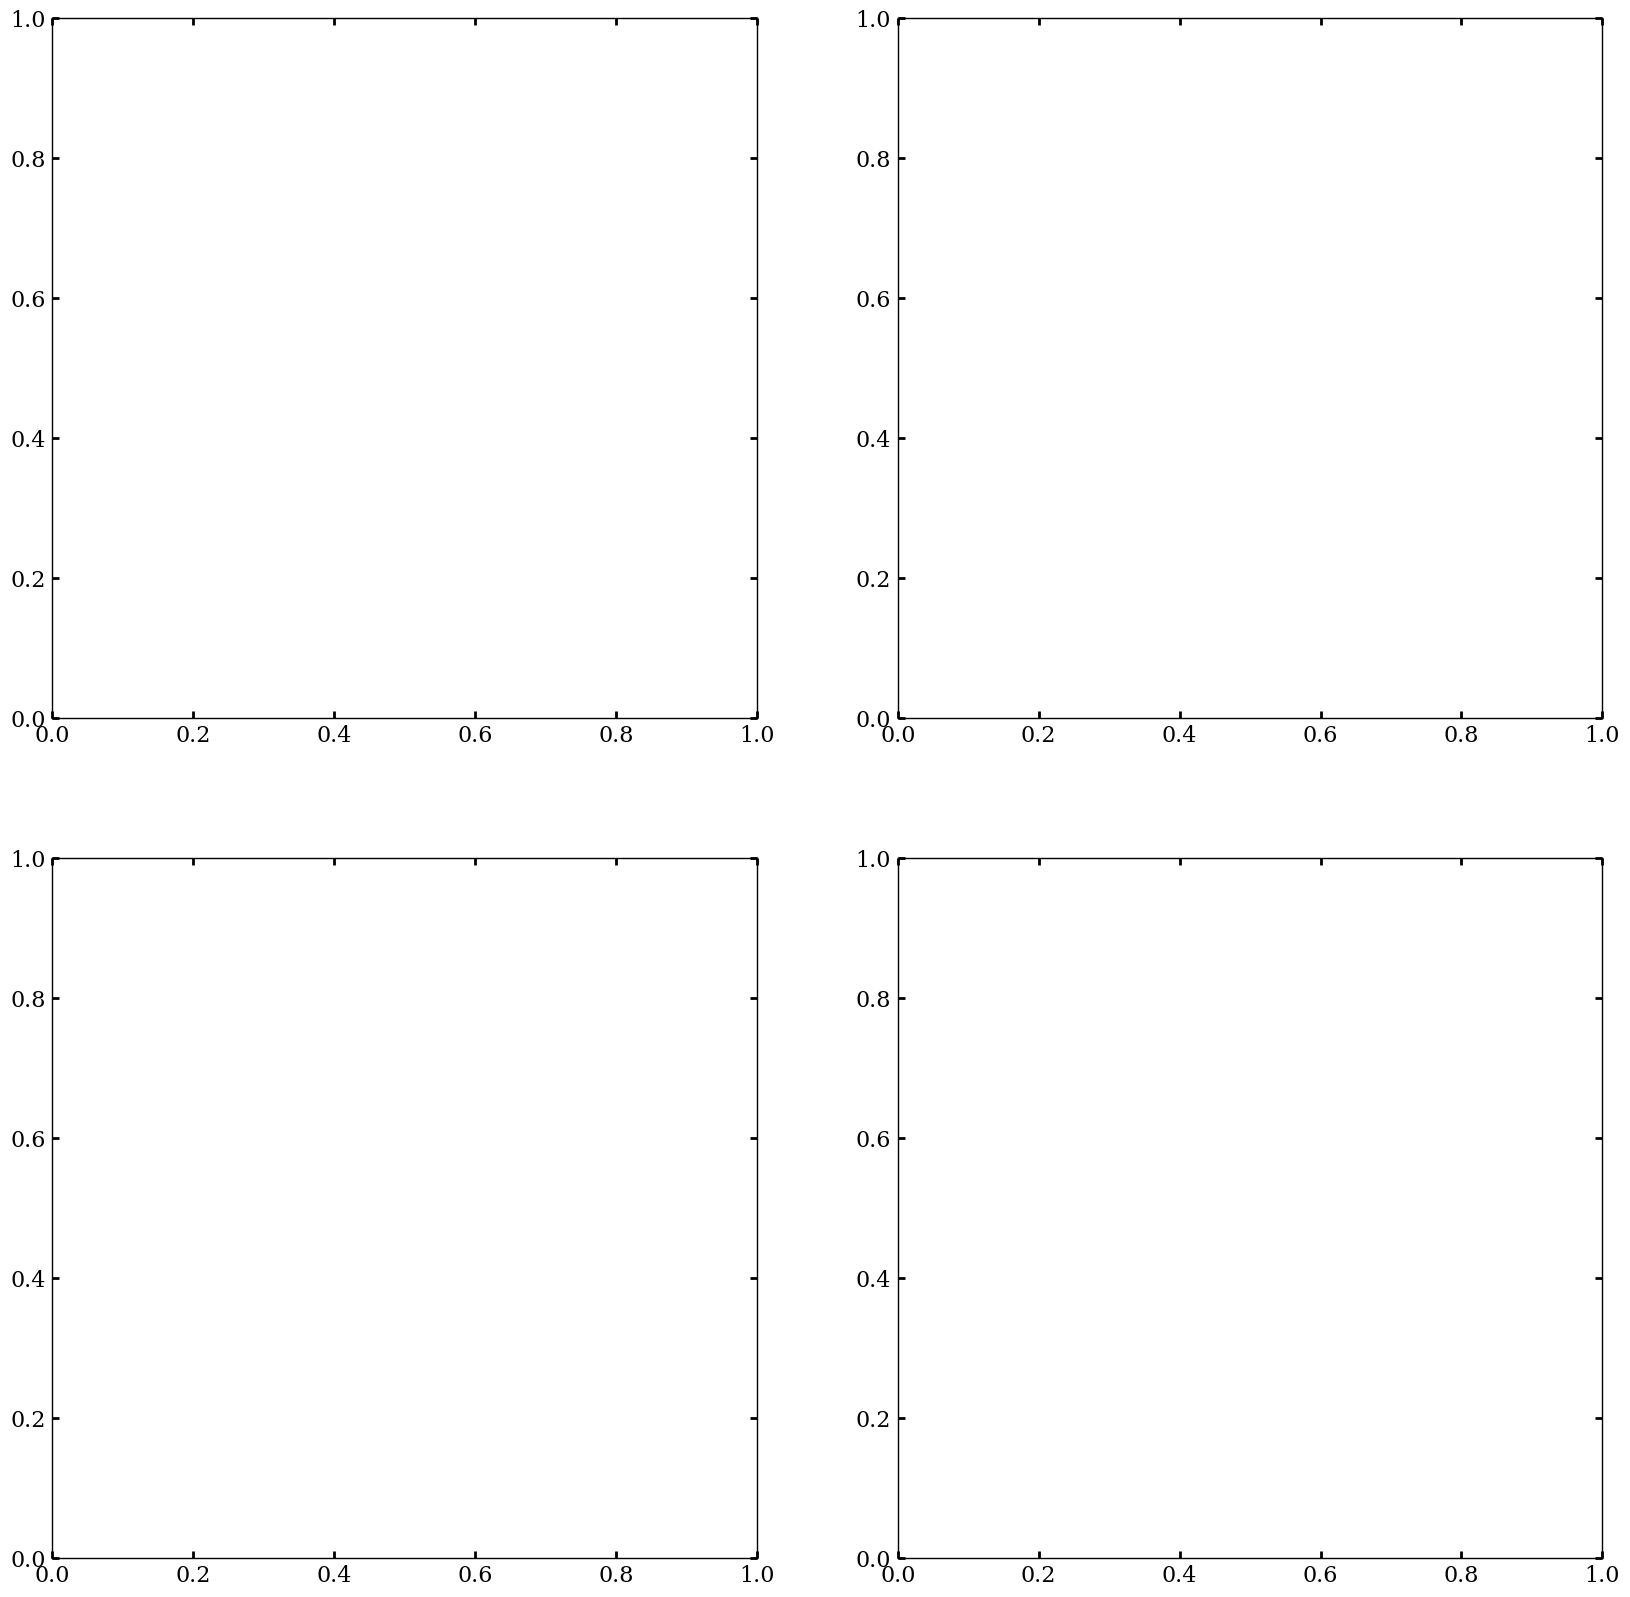

In [47]:

fig, ax = plt.subplots(2,2,figsize = (20,20))
axs = ax.flatten()
keys = list(allsnowmax_BC.keys())
for i, domain in enumerate(domains):
    color = clist[i][1]
    myax = axs[i]
    keys = snowmaxkeys[domain]
    
    for key in keys:
        ts = allsnowmax_BC.sel(gcm = key)
        myax.plot(years[1:], ts[1:], alpha = styles[domain], color = styles['BC'][1])
        ts = allsnowmax_noBC.sel(gcm = key)
        myax.plot(years[1:], ts[1:], alpha = styles[domain], color = styles['noBC'][1])
    '''
    trendline = lines_BC[domain] 
    myax.plot(x+1980, trendline, linestyle = styles['BC'][0], label = 'BC', linewidth = 3)
    trendline = lines_noBC[domain]
    myax.plot(x+1980, trendline, linestyle = styles['noBC'][0], label = 'noBC', linewidth = 3)
    # myax.set_title(domain)
    print(domain)
    if i %2 == 0: myax.set_ylabel(r'SWE [mm]')
    if i == 0: myax.legend(loc = 'lower left')
    coords = coords_dict[domain]
    inset_ax = inset_axes(myax, width="30%",  height="30%", loc=1, borderpad = 0.8, axes_kwargs=kwargs)
    inset_ax.tick_params(bottom=False)
    inset_ax.tick_params(left=False)
        
    inset_ax.plot(coords['XLONG'][0,:,0], coords['XLAT'][0,:,0], color =  color)
    inset_ax.plot(coords['XLONG'][0,:,-1], coords['XLAT'][0,:,-1], color =  color)
    inset_ax.plot(coords['XLONG'][0,0,:], coords['XLAT'][0,0,:], color = color)
    inset_ax.plot(coords['XLONG'][0,-1,:], coords['XLAT'][0,-1,:], color = color)
    
    world.boundary.plot(ax=inset_ax, linewidth =1, color = 'gray')
    inset_ax.set_xlim((-158,-83))
    inset_ax.set_ylim((8,69))
    '''
plt.show()
#fig.savefig('timeseries.jpg')